In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import time
from numba import njit,guvectorize,float64
import scipy.optimize as opt
from matplotlib import pyplot as plt
import math
#Set
t = np.arange(1, 101)
NT = len(t)

In [2]:
#Parameters
fosslim = 6000 # Maximum cumulative extraction fossil fuels (GtC); denoted by CCum
tstep  = 5 # Years per Period
ifopt  = 0 # Indicator where optimized is 1 and base is 0

In [3]:
#Preferences

elasmu = 1.45 #  Elasticity of marginal utility of consumption
prstp = 0.015 #   Initial rate of social time preference per year 

#** Population and technology
gama  = 0.300 #   Capital elasticity in production function         /.300 /
pop0  = 7403   # Initial world population 2015 (millions)          /7403 /
popadj = 0.134 #  Growth rate to calibrate to 2050 pop projection  /0.134/
popasym = 11500 # Asymptotic population (millions)                 /11500/
dk  = 0.100 #     Depreciation rate on capital (per year)           /.100 /
q0  = 105.5 #     Initial world gross output 2015 (trill 2010 USD) /105.5/
k0  = 223 #     Initial capital value 2015 (trill 2010 USD)        /223  /
a0  = 5.115 #     Initial level of total factor productivity       /5.115/
ga0  = 0.076 #    Initial growth rate for TFP per 5 years          /0.076/
dela  = 0.005 #   Decline rate of TFP per 5 years                  /0.005/

#** Emissions parameters
gsigma1  = -0.0152 # Initial growth of sigma (per year)            /-0.0152/
dsig  = -0.001 #   Decline rate of decarbonization (per period)    /-0.001 /
eland0 = 2.6 #  Carbon emissions from land 2015 (GtCO2 per year)   / 2.6   /
deland = 0.115 # Decline rate of land emissions (per period)        / .115  /
e0 = 35.85 #    Industrial emissions 2015 (GtCO2 per year)       /35.85  /
miu0  = 0.03 #   Initial emissions control rate for base case 2015  /.03    /

#** Carbon cycle
#* Initial Conditions
mat0 = 851 #  Initial Concentration in atmosphere 2015 (GtC)       /851  /
mu0  = 460 #  Initial Concentration in upper strata 2015 (GtC)     /460  /
ml0  = 1740 #  Initial Concentration in lower strata 2015 (GtC)    /1740 /
mateq = 588 # mateq Equilibrium concentration atmosphere  (GtC)    /588  /
mueq  = 360 # mueq Equilibrium concentration in upper strata (GtC) /360  /
mleq = 1720 # mleq Equilibrium concentration in lower strata (GtC) /1720 /

#* Flow paramaters, denoted by Phi_ij in the model
b12  = 0.12 #    Carbon cycle transition matrix                     /.12  /
b23  = 0.007 #   Carbon cycle transition matrix                    /0.007/
#* These are for declaration and are defined later
b11  = None   # Carbon cycle transition matrix
b21  = None  # Carbon cycle transition matrix
b22  = None  # Carbon cycle transition matrix
b32  = None  # Carbon cycle transition matrix
b33  = None  # Carbon cycle transition matrix
sig0  = None  # Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)

#** Climate model parameters
t2xco2  = 3.1 # Equilibrium temp impact (oC per doubling CO2)    / 3.1 /
fex0  = 0.5 #   2015 forcings of non-CO2 GHG (Wm-2)              / 0.5 /
fex1  = 1.0 #   2100 forcings of non-CO2 GHG (Wm-2)              / 1.0 /
tocean0  = 0.0068 # Initial lower stratum temp change (C from 1900) /.0068/
tatm0  = 0.85 #  Initial atmospheric temp change (C from 1900)    /0.85/
c1  = 0.1005 #     Climate equation coefficient for upper level  /0.1005/
c3  = 0.088 #     Transfer coefficient upper to lower stratum    /0.088/
c4  = 0.025 #     Transfer coefficient for lower level           /0.025/
fco22x  = 3.6813 # eta in the model; Eq.22 : Forcings of equilibrium CO2 doubling (Wm-2)   /3.6813 /

#** Climate damage parameters
a10  = 0 #     Initial damage intercept                         /0   /
a20  = None #     Initial damage quadratic term
a1  = 0 #      Damage intercept                                 /0   /
a2  = 0.00236 #      Damage quadratic term                     /0.00236/
a3  = 2.00 #      Damage exponent                              /2.00   /

#** Abatement cost
expcost2 = 2.6 # Theta2 in the model, Eq. 10 Exponent of control cost function             / 2.6  /
pback  = 550 #   Cost of backstop 2010$ per tCO2 2015          / 550  /
gback  = 0.025 #   Initial cost decline backstop cost per period / .025/
limmiu  = 1.2 #  Upper limit on control rate after 2150        / 1.2 /
tnopol  = 45 #  Period before which no emissions controls base  / 45   /
cprice0  = 2 # Initial base carbon price (2010$ per tCO2)      / 2    /
gcprice  = 0.02 # Growth rate of base carbon price per year     /.02  /

#** Scaling and inessential parameters
#* Note that these are unnecessary for the calculations
#* They ensure that MU of first period's consumption =1 and PV cons = PV utilty
scale1  = 0.0302455265681763 #    Multiplicative scaling coefficient           /0.0302455265681763 /
scale2  = -10993.704 #    Additive scaling coefficient       /-10993.704/;

In [4]:
#* Parameters for long-run consistency of carbon cycle 
#(Question)
b11 = 1 - b12
b21 = b12*mateq/mueq
b22 = 1 - b21 - b23
b32 = b23*mueq/mleq
b33 = 1 - b32

#* Further definitions of parameters
a20 = a2
sig0 = e0/(q0*(1-miu0)) #From Eq. 14
lam = fco22x/ t2xco2 #From Eq. 25

l = np.zeros(NT)
l[0] = pop0 #Labor force
al = np.zeros(NT) 
al[0] = a0
gsig = np.zeros(NT) 
gsig[0] = gsigma1
sigma = np.zeros(NT)
sigma[0]= sig0
ga = ga0 * np.exp(-dela*5*(t-1)) #TFP growth rate dynamics, Eq. 7
pbacktime = pback * (1-gback)**(t-1) #Backstop price
etree = eland0*(1-deland)**(t-1) #Emissions from deforestration
rr = 1/((1+prstp)**(tstep*(t-1))) #Eq. 3
#The following three equations define the exogenous radiative forcing; used in Eq. 23  
forcoth = np.full(NT,fex0)
forcoth[0:18] = forcoth[0:18] + (1/17)*(fex1-fex0)*(t[0:18]-1)
forcoth[18:NT] = forcoth[18:NT] + (fex1-fex0)
optlrsav = (dk + .004)/(dk + .004*elasmu + prstp)*gama #Optimal long-run savings rate used for transversality (Question)
cost1 = np.zeros(NT)
cumetree = np.zeros(NT)
cumetree[0] = 100
cpricebase = cprice0*(1+gcprice)**(5*(t-1)) 

In [5]:
@njit('(float64[:], int32)')
def InitializeLabor(il,iNT):
    for i in range(1,iNT):
        il[i] = il[i-1]*(popasym / il[i-1])**popadj

@njit('(float64[:], int32)')        
def InitializeTFP(ial,iNT):
    for i in range(1,iNT):
        ial[i] = ial[i-1]/(1-ga[i-1])
        
@njit('(float64[:], int32)')        
def InitializeGrowthSigma(igsig,iNT):
    for i in range(1,iNT):
        igsig[i] = igsig[i-1]*((1+dsig)**tstep)
        
@njit('(float64[:], float64[:],float64[:],int32)')        
def InitializeSigma(isigma,igsig,icost1,iNT):
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1] * tstep)
        icost1[i] = pbacktime[i] * isigma[i]  / expcost2 /1000
        
@njit('(float64[:], int32)')        
def InitializeCarbonTree(icumetree,iNT):
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + etree[i-1]*(5/3.666)


In [6]:
"""
Functions of the model
"""

"""
First: Functions related to emissions of carbon and weather damages
"""

# Retuns the total carbon emissions; Eq. 18
@njit('float64(float64[:],int32)') 
def fE(iEIND,index):
    return iEIND[index] + etree[index]

#Eq.14: Determines the emission of carbon by industry EIND
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fEIND(iYGROSS, iMIU, isigma,index):
    return isigma[index] * iYGROSS[index] * (1 - iMIU[index])

#Cumulative industrial emission of carbon
@njit('float64(float64[:],float64[:],int32)') 
def fCCA(iCCA,iEIND,index):
    return iCCA[index-1] + iEIND[index-1] * 5 / 3.666

#Cumulative total carbon emission
@njit('float64(float64[:],float64[:],int32)')
def fCCATOT(iCCA,icumetree,index):
    return iCCA[index] + icumetree[index]

#Eq. 22: the dynamics of the radiative forcing
@njit('float64(float64[:],int32)')
def fFORC(iMAT,index):
    return fco22x * np.log(iMAT[index]/588.000)/np.log(2) + forcoth[index]

# Dynamics of Omega; Eq.9
@njit('float64(float64[:],int32)')
def fDAMFRAC(iTATM,index):
    return a1*iTATM[index] + a2*iTATM[index]**a3

#Calculate damages as a function of Gross industrial production; Eq.8 
@njit('float64(float64[:],float64[:],int32)')
def fDAMAGES(iYGROSS,iDAMFRAC,index):
    return iYGROSS[index] * iDAMFRAC[index]

#Dynamics of Lambda; Eq. 10 - cost of the reudction of carbon emission (Abatement cost)
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fABATECOST(iYGROSS,iMIU,icost1,index):
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

#Marginal Abatement cost
@njit('float64(float64[:],int32)')
def fMCABATE(iMIU,index):
    return pbacktime[index] * iMIU[index]**(expcost2-1)

#Price of carbon reduction
@njit('float64(float64[:],int32)')
def fCPRICE(iMIU,index):
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

#Eq. 19: Dynamics of the carbon concentration in the atmosphere
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMAT(iMAT,iMU,iE,index):
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + iE[index-1] * 5 / 3.666

#Eq. 21: Dynamics of the carbon concentration in the ocean LOW level
@njit('float64(float64[:],float64[:],int32)') 
def fML(iML,iMU,index):
    if(index == 0):
        return ml0
    else:
        return iML[index-1] * b33  + iMU[index-1] * b23

#Eq. 20: Dynamics of the carbon concentration in the ocean UP level
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMU(iMAT,iMU,iML,index):
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

#Eq. 23: Dynamics of the atmospheric temperature
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fTATM(iTATM,iFORC,iTOCEAN,index):
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1 * (iFORC[index] - (fco22x/t2xco2) * iTATM[index-1] - c3 * (iTATM[index-1] - iTOCEAN[index-1]))

#Eq. 24: Dynamics of the ocean temperature
@njit('float64(float64[:],float64[:],int32)')
def fTOCEAN(iTATM,iTOCEAN,index):
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4 * (iTATM[index-1] - iTOCEAN[index-1])

"""
Second: Function related to economic variables
"""

#The total production without climate losses denoted previously by YGROSS
@njit('float64(float64[:],float64[:],float64[:],int32)')
def fYGROSS(ial,il,iK,index):
    return ial[index] * ((il[index]/1000)**(1-gama)) * iK[index]**gama

#The production under the climate damages cost
@njit('float64(float64[:],float64[:],int32)')
def fYNET(iYGROSS, iDAMFRAC, index):
    return iYGROSS[index] * (1 - iDAMFRAC[index])

#Production after abatement cost
@njit('float64(float64[:],float64[:],int32)')
def fY(iYNET,iABATECOST,index):
    return iYNET[index] - iABATECOST[index]

#Consumption Eq. 11
@njit('float64(float64[:],float64[:],int32)')
def fC(iY,iI,index):
    return iY[index] - iI[index]

#Per capita consumption, Eq. 12
@njit('float64(float64[:],float64[:],int32)')
def fCPC(iC,il,index):
    return 1000 * iC[index] / il[index]

#Saving policy: investment
@njit('float64(float64[:],float64[:],int32)')
def fI(iS,iY,index):
    return iS[index] * iY[index] 

#Capital dynamics Eq. 13
@njit('float64(float64[:],float64[:],int32)')
def fK(iK,iI,index):
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

#Interest rate equation; Eq. 26 added in personal notes
@njit('float64(float64[:],int32)')
def fRI(iCPC,index):
    return (1 + prstp) * (iCPC[index+1]/iCPC[index])**(elasmu/tstep) - 1

#Periodic utility: A form of Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fCEMUTOTPER(iPERIODU,il,index):
    return iPERIODU[index] * il[index] * rr[index]

#The term between brackets in Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fPERIODU(iC,il,index):
    return ((iC[index]*1000/il[index])**(1-elasmu) - 1) / (1 - elasmu) - 1

#utility function
@guvectorize([(float64[:], float64[:])], '(n), (m)')
def fUTILITY(iCEMUTOTPER, resUtility):
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2


In [7]:

"""
In this part we implement the objective function
"""

# * Control rate limits
MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:29] = 1
MIU_lo[0] = miu0
MIU_up[0] = miu0
MIU_lo[MIU_lo==MIU_up] = 0.99999*MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))
# * Control variables
lag10 = t > NT - 10
S_lo = np.full(NT,1e-1)
S_lo[lag10] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag10] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))
    
# Arbitrary starting values for the control variables:
S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

K = np.zeros(NT)
YGROSS = np.zeros(NT)
EIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(NT)
DAMAGES = np.zeros(NT)
ABATECOST = np.zeros(NT)
MCABATE = np.zeros(NT)
CPRICE = np.zeros(NT)
YNET = np.zeros(NT)
Y = np.zeros(NT)
I = np.zeros(NT)
C = np.zeros(NT)
CPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)

In [8]:
#The objective function
#It returns the utility as scalar
def fOBJ(x,sign,iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = x[0:iNT]
    iS = x[iNT:(2*iNT)]
    
    for i in range(iNT):
        iK[i] = fK(iK,iI,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iE[i] = fE(iEIND,i)
        iCCA[i] = fCCA(iCCA,iEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS, iDAMFRAC, i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iCPC[i] = fCPC(iC,il,i)
        iPERIODU[i] = fPERIODU(iC,il,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,il,i)
        iRI = fRI(iCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return sign*resUtility[0]

In [9]:
InitializeLabor(l,NT)
InitializeTFP(al,NT)
InitializeGrowthSigma(gsig,NT)
InitializeSigma(sigma,gsig,cost1,NT)
InitializeCarbonTree(cumetree,NT)

In [10]:
class OPTIM(object):
    def __init__(self):
        super(OPTIM, self).__init__()
    
    def step(self, action):
        global x, x1, x2
        
        miu = action[0]
        s = action[1]
        x1 = np.append(x1, miu)
        x2 = np.append(x2, s)
        x = np.concatenate([x1,x2])
        obs_ = np.array([miu,s])
        #obs_ = np.array([miu,s,steps+1])
        
        reward = fOBJ(x,1,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
         CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,j+1)
        #if reward == np.nan:
            #reward = 0
            
        done = bool(j==99)
        #if done == True:
            #if reward > 4500:
             #   R = 2
            #else:
            #    R = 1
        #else:
            #R = 0
        return obs_, reward, done
        
    def reset(self):
        return np.array([MIU_start[0],S_start[0]])
        #return np.array([MIU_start[0],S_start[0],0])


In [11]:
import tensorflow as tf
import numpy as np
import gym
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

#####################  hyper parameters  ####################

MAX_EPISODES = 1000
MAX_EP_STEPS = 100
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32


In [12]:
###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self, a_dim, s_dim,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.compat.v1.Session()

        self.a_dim, self.s_dim, = a_dim, s_dim, 
        tf.compat.v1.disable_eager_execution()
        self.S = tf.compat.v1.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.compat.v1.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.compat.v1.placeholder(tf.float32, [None, 1], 'r')

        with tf.compat.v1.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.compat.v1.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [tf.compat.v1.assign(t, (1 - TAU) * t + TAU * e)
                             for t, e in zip(self.at_params + self.ct_params, self.ae_params + self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.compat.v1.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.compat.v1.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.compat.v1.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.compat.v1.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.compat.v1.variable_scope(scope):
            net = layers.Dense(3000, activation=tf.nn.relu, name='l1', trainable=trainable)(s)
            a = layers.Dense(self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)(net)
            return a

    def _build_c(self, s, a, scope, trainable):
        with tf.compat.v1.variable_scope(scope):
            n_l1 = 3000
            w1_s = tf.compat.v1.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.compat.v1.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.compat.v1.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return layers.Dense(1, trainable=trainable)(net)  # Q(s,a)

In [13]:
###############################  training  ####################################
import random
random.seed(42)

env = OPTIM()

s_dim = 2
a_dim = 2

ddpg = DDPG(a_dim, s_dim)

var = 3  # control exploration
t1 = time.time()
episode_count = 0
Reward = []
epi = []

for i in range(MAX_EPISODES):
    s = env.reset()
    ep_reward = 0
    x1 = []
    x2 = []
    
    for j in range(MAX_EP_STEPS):
        x = []
        
        # Add exploration noise
        a = ddpg.choose_action(s)

        a[0] = np.clip(np.random.normal(a[0], var), MIU_lo[j], MIU_up[j]) 
        a[1] = np.clip(np.random.normal(a[1], var), S_lo[j], S_up[j]) 
       
        s_, r, done = env.step(a)

        ddpg.store_transition(s, a, r, s_)

        if ddpg.pointer > MEMORY_CAPACITY:
            var *= .9995    # decay the action randomness
            ddpg.learn()

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS-1:
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, 'current reward', r)
            break
    if r > 4500:
        print('Problem solved!')
        break
            
    episode_count += 1
    Reward.append(r)
    epi.append(episode_count)
print('Running time: ', time.time() - t1)

Episode: 0  Reward: -83125 Explore: 3.00 current reward 1324.9828846665241
Episode: 1  Reward: -71421 Explore: 3.00 current reward -698.2019593270143
Episode: 2  Reward: -112442 Explore: 3.00 current reward -1109.762475285308
Episode: 3  Reward: 109852 Explore: 3.00 current reward 1148.285771109864
Episode: 4  Reward: -62531 Explore: 3.00 current reward -604.7893713051344
Episode: 5  Reward: 39045 Explore: 3.00 current reward 349.87755436323096
Episode: 6  Reward: -147382 Explore: 3.00 current reward -1472.6807437220905
Episode: 7  Reward: -17239 Explore: 3.00 current reward -256.18155918879893
Episode: 8  Reward: -143180 Explore: 3.00 current reward -1270.0665634950929
Episode: 9  Reward: -159225 Explore: 3.00 current reward -1708.0449424265062
Episode: 10  Reward: -95804 Explore: 3.00 current reward -1055.4994467144625
Episode: 11  Reward: -104545 Explore: 3.00 current reward -915.6228917628487
Episode: 12  Reward: -251872 Explore: 3.00 current reward -2589.9487045678106
Episode: 13 

Episode: 108  Reward: 134420 Explore: 1.91 current reward 1285.3227153097832
Episode: 109  Reward: 194352 Explore: 1.82 current reward 1990.9713359576108
Episode: 110  Reward: 153881 Explore: 1.73 current reward 1584.7865940316824
Episode: 111  Reward: 72233 Explore: 1.65 current reward 627.7707273630513
Episode: 112  Reward: 233498 Explore: 1.57 current reward 2408.4095598535296
Episode: 113  Reward: 328216 Explore: 1.49 current reward 3356.9355652104405
Episode: 114  Reward: 265990 Explore: 1.42 current reward 2574.3013367827916
Episode: 115  Reward: 292477 Explore: 1.35 current reward 3077.7770810485
Episode: 116  Reward: 255996 Explore: 1.28 current reward 2478.8931014517348
Episode: 117  Reward: 232686 Explore: 1.22 current reward 2294.824858756303
Episode: 118  Reward: -50759 Explore: 1.16 current reward -656.1969442537265
Episode: 119  Reward: 8374 Explore: 1.10 current reward 86.38473552875985
Episode: 120  Reward: -116582 Explore: 1.05 current reward -1172.9466349673694
Episod

Episode: 216  Reward: 260168 Explore: 0.01 current reward 2595.520291663608
Episode: 217  Reward: 265610 Explore: 0.01 current reward 2660.3859175220095
Episode: 218  Reward: 274442 Explore: 0.01 current reward 2746.4923797764404
Episode: 219  Reward: 268737 Explore: 0.01 current reward 2684.8319659283698
Episode: 220  Reward: 270855 Explore: 0.01 current reward 2711.469675304903
Episode: 221  Reward: 268459 Explore: 0.01 current reward 2683.2996907857305
Episode: 222  Reward: 266655 Explore: 0.01 current reward 2664.825963049341
Episode: 223  Reward: 268934 Explore: 0.01 current reward 2690.4109484127275
Episode: 224  Reward: 270621 Explore: 0.01 current reward 2703.7490297252552
Episode: 225  Reward: 264579 Explore: 0.01 current reward 2646.22126397383
Episode: 226  Reward: 263337 Explore: 0.01 current reward 2630.6673994608263
Episode: 227  Reward: 265798 Explore: 0.00 current reward 2659.791346126025
Episode: 228  Reward: 266999 Explore: 0.00 current reward 2669.141460447481
Episod

Episode: 324  Reward: 375315 Explore: 0.00 current reward 3752.8908309343915
Episode: 325  Reward: 376622 Explore: 0.00 current reward 3766.43114167121
Episode: 326  Reward: 377039 Explore: 0.00 current reward 3770.4939347258696
Episode: 327  Reward: 376260 Explore: 0.00 current reward 3762.464757507845
Episode: 328  Reward: 375814 Explore: 0.00 current reward 3758.212730936144
Episode: 329  Reward: 377073 Explore: 0.00 current reward 3770.9019004482925
Episode: 330  Reward: 376623 Explore: 0.00 current reward 3766.3810449923403
Episode: 331  Reward: 376128 Explore: 0.00 current reward 3761.211120943348
Episode: 332  Reward: 376720 Explore: 0.00 current reward 3767.2709786720843
Episode: 333  Reward: 377128 Explore: 0.00 current reward 3770.972827010097
Episode: 334  Reward: 376143 Explore: 0.00 current reward 3761.4077361016807
Episode: 335  Reward: 376045 Explore: 0.00 current reward 3760.5483654818963
Episode: 336  Reward: 375323 Explore: 0.00 current reward 3753.2267575319547
Episo

Episode: 432  Reward: 415680 Explore: 0.00 current reward 4156.902312711985
Episode: 433  Reward: 415837 Explore: 0.00 current reward 4158.3817823250465
Episode: 434  Reward: 416762 Explore: 0.00 current reward 4167.526323020258
Episode: 435  Reward: 416860 Explore: 0.00 current reward 4168.578581838487
Episode: 436  Reward: 417630 Explore: 0.00 current reward 4176.073033593031
Episode: 437  Reward: 417883 Explore: 0.00 current reward 4179.0866860647075
Episode: 438  Reward: 418084 Explore: 0.00 current reward 4180.774883990962
Episode: 439  Reward: 419301 Explore: 0.00 current reward 4192.734321827822
Episode: 440  Reward: 419351 Explore: 0.00 current reward 4193.625504563555
Episode: 441  Reward: 420168 Explore: 0.00 current reward 4201.473375049636
Episode: 442  Reward: 420388 Explore: 0.00 current reward 4203.821577856374
Episode: 443  Reward: 419873 Explore: 0.00 current reward 4198.9385695498
Episode: 444  Reward: 420859 Explore: 0.00 current reward 4208.407451807465
Episode: 445

Episode: 540  Reward: 436834 Explore: 0.00 current reward 4368.319006006777
Episode: 541  Reward: 436843 Explore: 0.00 current reward 4368.422744337091
Episode: 542  Reward: 436838 Explore: 0.00 current reward 4368.374526108446
Episode: 543  Reward: 436964 Explore: 0.00 current reward 4369.494721589148
Episode: 544  Reward: 436904 Explore: 0.00 current reward 4369.1380787584
Episode: 545  Reward: 436928 Explore: 0.00 current reward 4369.246617222216
Episode: 546  Reward: 436997 Explore: 0.00 current reward 4369.945199121532
Episode: 547  Reward: 437002 Explore: 0.00 current reward 4370.004379669555
Episode: 548  Reward: 437052 Explore: 0.00 current reward 4370.514628923285
Episode: 549  Reward: 437143 Explore: 0.00 current reward 4371.345420913776
Episode: 550  Reward: 437159 Explore: 0.00 current reward 4371.558849211464
Episode: 551  Reward: 437183 Explore: 0.00 current reward 4371.845305365636
Episode: 552  Reward: 437194 Explore: 0.00 current reward 4371.929700708524
Episode: 553  

Episode: 648  Reward: 443072 Explore: 0.00 current reward 4433.300928871158
Episode: 649  Reward: 444109 Explore: 0.00 current reward 4441.408404550937
Episode: 650  Reward: 442961 Explore: 0.00 current reward 4427.284230969335
Episode: 651  Reward: 437778 Explore: 0.00 current reward 4372.080639057516
Episode: 652  Reward: 440532 Explore: 0.00 current reward 4409.6285696601135
Episode: 653  Reward: 443547 Explore: 0.00 current reward 4439.442245505625
Episode: 654  Reward: 444543 Explore: 0.00 current reward 4445.488785132671
Episode: 655  Reward: 444016 Explore: 0.00 current reward 4439.574235137874
Episode: 656  Reward: 442291 Explore: 0.00 current reward 4420.771579061757
Episode: 657  Reward: 444177 Explore: 0.00 current reward 4444.667226539446
Episode: 658  Reward: 444031 Explore: 0.00 current reward 4440.086650487561
Episode: 659  Reward: 444549 Explore: 0.00 current reward 4444.403330112844
Episode: 660  Reward: 444828 Explore: 0.00 current reward 4449.691389072586
Episode: 66

Episode: 756  Reward: 449735 Explore: 0.00 current reward 4496.914417424276
Episode: 757  Reward: 449675 Explore: 0.00 current reward 4496.530710232295
Episode: 758  Reward: 449512 Explore: 0.00 current reward 4495.6798448743575
Episode: 759  Reward: 449653 Explore: 0.00 current reward 4496.28565183215
Episode: 760  Reward: 449597 Explore: 0.00 current reward 4495.7487541241335
Episode: 761  Reward: 449553 Explore: 0.00 current reward 4495.634161141705
Episode: 762  Reward: 449559 Explore: 0.00 current reward 4495.608719418717
Episode: 763  Reward: 449646 Explore: 0.00 current reward 4496.1550936069925
Episode: 764  Reward: 449537 Explore: 0.00 current reward 4495.18392192287
Episode: 765  Reward: 449477 Explore: 0.00 current reward 4495.145141483301
Episode: 766  Reward: 449564 Explore: 0.00 current reward 4495.856343282274
Episode: 767  Reward: 449657 Explore: 0.00 current reward 4496.2969746014405
Episode: 768  Reward: 449615 Explore: 0.00 current reward 4496.362564416611
Episode: 7

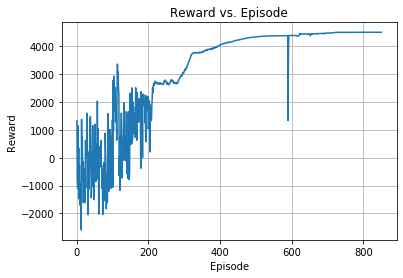

In [14]:
fig, ax = plt.subplots()
ax.plot(epi, Reward)

ax.set(xlabel='Episode', ylabel='Reward',
       title='Reward vs. Episode')
ax.grid()
plt.show()